In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.scale import LogScale
import json
from utils import dref_dataframe

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

def parse_logs(path: Path, iter: int = 1) -> pd.DataFrame:
    datas = []
    for i in range(iter):
        data = pd.read_csv(path / f"out_{i}.csv")
        meta = json.load((path / f"meta.json").open())
        data["iter"] = i
        data["shrink"] = (data["shrink"] / 1e9) / meta["args"]["mem"]
        data["grow"] = (data["grow"] / 1e9) / meta["args"]["mem"]
        if "touch" in data.columns:
            data["touch"] = (data["touch"] / 1e9) / meta["args"]["mem"]
        datas.append(data)
    data = pd.concat(datas)
    match path.stem:
        case n if n.endswith("base-manual"): mode = "virtio-balloon"
        case n if n.endswith("huge-manual"): mode = "virtio-balloon-huge"
        case n if n.endswith("virtio-mem-movable"): mode = "virtio-mem"
        case n if n.endswith("virtio-mem-movable-vfio"): mode = "virtio-mem+VFIO"
        case n if n.endswith("llfree-manual"): mode = "HyperAlloc"
        case n if n.endswith("llfree-manual-vfio"): mode = "HyperAlloc+VFIO"
        case m: mode = m
    data["mode"] = mode
    return pd.DataFrame(data)


     shrink      grow     touch  iter                 mode
0  0.643882  0.355466  1.514500     0       virtio-balloon
0  0.871301  0.356209  1.520063     1       virtio-balloon
0  0.880757  0.356859  1.522500     2       virtio-balloon
0  0.005485  0.002566  0.779563     0  virtio-balloon-huge
0  0.005719  0.002571  0.776500     1  virtio-balloon-huge
0  0.005854  0.002581  0.776750     2  virtio-balloon-huge
0  0.027814  0.007979  0.784500     0           virtio-mem
0  0.027777  0.008023  0.782813     1           virtio-mem
0  0.024624  0.007988  0.786438     2           virtio-mem
0  0.042115  0.174917  0.748500     0      virtio-mem+VFIO
0  0.040648  0.174810  0.749750     1      virtio-mem+VFIO
0  0.037225  0.173654  0.760813     2      virtio-mem+VFIO
0  0.002253  0.000097  0.831562     0           HyperAlloc
0  0.002526  0.000098  0.824187     1           HyperAlloc
0  0.002258  0.000101  0.826000     2           HyperAlloc
0  0.014857  0.000098  0.851125     0      HyperAlloc+VF

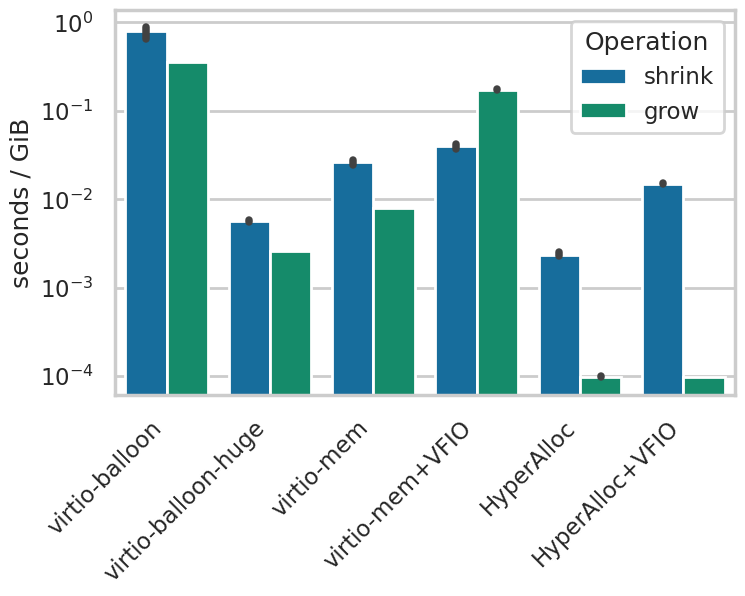

In [8]:
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]
data = pd.concat([parse_logs(p, 3) for p in paths])
print(data)

plt.figure(figsize=(8, 5))
pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
p = sns.barplot(pgd, y="time", x="mode", hue="op")
p.legend(title="Operation")
p.set_yscale("log")
p.set_ylabel("seconds / GiB")
p.set_xlabel(None)
_ = p.set_xticklabels(p.get_xticklabels(), rotation=45, ha="right")

     shrink      grow     touch  iter                 mode
0  0.871301  0.356209  1.520063     1       virtio-balloon
0  0.880757  0.356859  1.522500     2       virtio-balloon
0  0.005719  0.002571  0.776500     1  virtio-balloon-huge
0  0.005854  0.002581  0.776750     2  virtio-balloon-huge
0  0.027777  0.008023  0.782813     1           virtio-mem
0  0.024624  0.007988  0.786438     2           virtio-mem
0  0.040648  0.174810  0.749750     1      virtio-mem+VFIO
0  0.037225  0.173654  0.760813     2      virtio-mem+VFIO
0  0.002526  0.000098  0.824187     1           HyperAlloc
0  0.002258  0.000101  0.826000     2           HyperAlloc
0  0.015267  0.000097  0.855062     1      HyperAlloc+VFIO
0  0.014844  0.000098  0.853750     2      HyperAlloc+VFIO
     shrink      grow  iter                 mode
0  0.496569  0.346702     1       virtio-balloon
0  0.496706  0.346576     2       virtio-balloon
0  0.002944  0.002565     1  virtio-balloon-huge
0  0.002927  0.002563     2  virtio-b

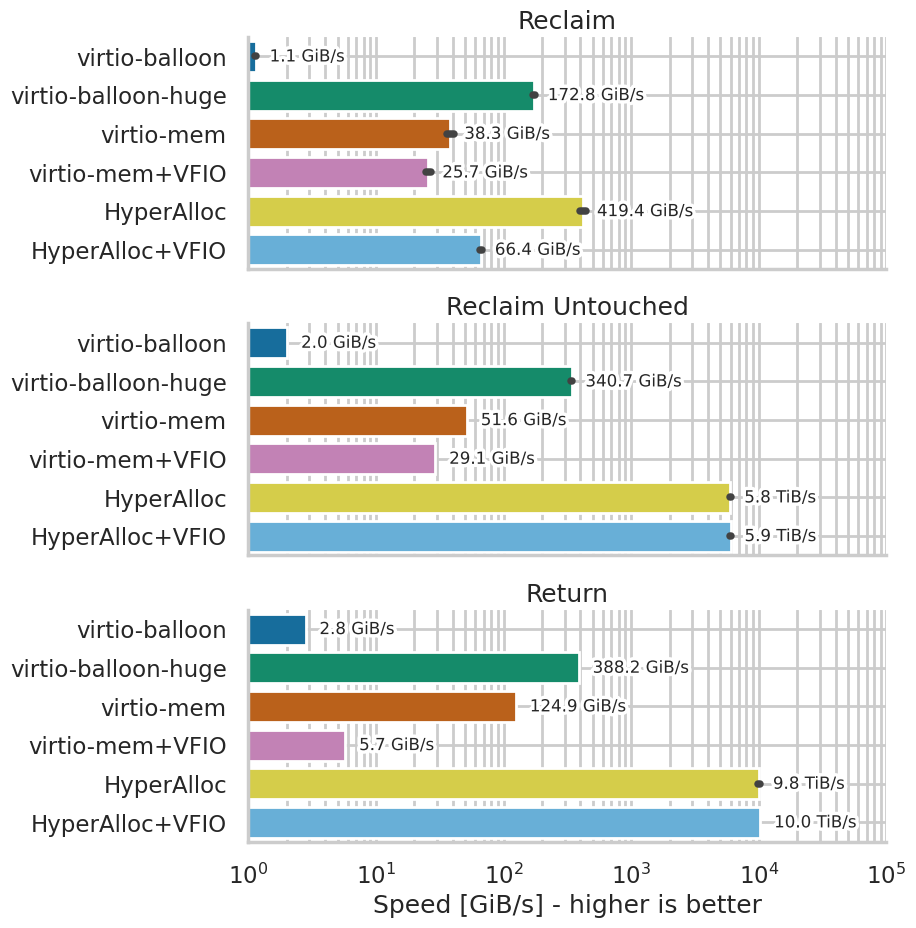

In [13]:
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
data = data[data["iter"] > 0]
print(data)

pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow", "touch"],
                var_name="op", value_name="time")
pgd["time"] = 1 / pgd["time"]

paths = [
    Path("inflate/latest-nofault-base-manual"),
    Path("inflate/latest-nofault-huge-manual"),
    Path("inflate/latest-nofault-virtio-mem-movable"),
    Path("inflate/latest-nofault-virtio-mem-movable-vfio"),
    Path("inflate/latest-nofault-llfree-manual"),
    Path("inflate/latest-nofault-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
data = data[data["iter"] > 0]
print(data)

pgd1 = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
pgd1["time"] = 1 / pgd1["time"]
pgd1 = pgd1[pgd1["op"] == "shrink"]
pgd1["op"] = "Reclaim Untouched"

pgd = pd.concat([pgd, pgd1])
pgd.loc[pgd["op"] == "shrink", "op"] = "Reclaim"
pgd.loc[pgd["op"] == "grow", "op"] = "Return"
pgd.loc[pgd["op"] == "touch", "op"] = "Access"
print(pgd["op"].unique())

print(pgd["time"].max())
p = sns.catplot(pgd, kind="bar", y="mode", hue="mode", x="time", dodge=False,
                row="op", row_order=["Reclaim", "Reclaim Untouched", "Return"],
                legend=False, aspect=3, height=3.2)
p.set(xlabel="Speed [GiB/s] - higher is better")
p.set(ylabel=None)
p.set(xlim=(1, 1e5))

def mem_fmt(x: float) -> str:
    x *= 1024**3
    sizes = ["TiB", "GiB", "MiB", "KiB"]
    for i, suffix in enumerate(sizes):
        mul = 1024 ** (len(sizes) - i)
        if x > mul: return f"{x/mul:.1f} {suffix}/s"
    return f"{x:.2} B/s"

for ax in p.axes_dict.values():
    ax.set_xscale("log", base=10)
    ax.grid(True, which="both")
    for c in ax.containers:
        ax.bar_label(c, fmt=mem_fmt, fontsize=12, padding=10,
                     path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])
p.set_titles(row_template="{row_name}")
p.figure.savefig("inflate/inflate.pdf", bbox_inches="tight")
dref_dataframe("inflate", Path("inflate"), ["mode", "iter", "op"], pgd)

     shrink      grow     touch  iter                 mode   install
0  0.871301  0.356209  1.520063     1       virtio-balloon  1.876271
0  0.880757  0.356859  1.522500     2       virtio-balloon  1.879359
0  0.005719  0.002571  0.776500     1  virtio-balloon-huge  0.779071
0  0.005854  0.002581  0.776750     2  virtio-balloon-huge  0.779331
0  0.027777  0.008023  0.782813     1           virtio-mem  0.790835
0  0.024624  0.007988  0.786438     2           virtio-mem  0.794425
0  0.040648  0.174810  0.749750     1      virtio-mem+VFIO  0.924560
0  0.037225  0.173654  0.760813     2      virtio-mem+VFIO  0.934467
0  0.002526  0.000098  0.824187     1           HyperAlloc  0.824286
0  0.002258  0.000101  0.826000     2           HyperAlloc  0.826101
0  0.015267  0.000097  0.855062     1      HyperAlloc+VFIO  0.855160
0  0.014844  0.000098  0.853750     2      HyperAlloc+VFIO  0.853848


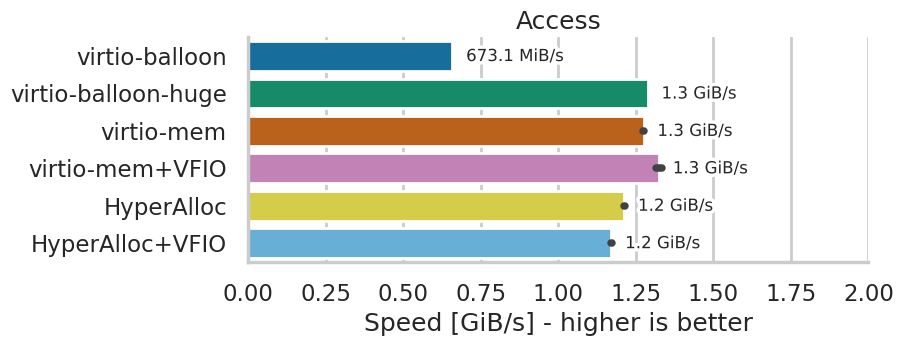

In [20]:
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
data = data[data["iter"] > 0]
data["install"] = data["grow"] + data["touch"]
print(data)

pgd = data.melt(id_vars=["mode", "iter"], value_vars=["touch"],
                var_name="op", value_name="time")
pgd["time"] = 1 / pgd["time"]
pgd.loc[pgd["op"] == "touch", "op"] = "Access"

p = sns.catplot(pgd, kind="bar", y="mode", hue="mode", x="time", dodge=False,
                row="op", row_order=["Access"],
                legend=False, aspect=9.6/3.8, height=3.8)
p.set(xlabel="Speed [GiB/s] - higher is better")
p.set(ylabel=None)
p.set(xlim=(0, 2))

def mem_fmt(x: float) -> str:
    x *= 1024**3
    sizes = ["TiB", "GiB", "MiB", "KiB"]
    for i, suffix in enumerate(sizes):
        mul = 1024 ** (len(sizes) - i)
        if x > mul: return f"{x/mul:.1f} {suffix}/s"
    return f"{x:.2} B/s"

for ax in p.axes_dict.values():
    # ax.set_xscale("log", base=10)
    for c in ax.containers:
        ax.bar_label(c, fmt=mem_fmt, fontsize=12, padding=10,
                     path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])
p.set_titles(row_template="{row_name}")
p.figure.savefig("inflate/inflate_touch.pdf", bbox_inches="tight")